## **Modelos de Detecção**


**O objetivo deste notebook é treinar modelos de aprendizado profundo para identificar e localizar a presença de uma determinada fruta em uma imagem de entrada.**

## **Bibliotecas utilizadas**

In [ ]:
%%capture
!pip install ultralytics
!pip install opendatasets

In [ ]:
import os
import cv2
import yaml
import json
import shutil
import requests
import numpy as np
import torch
import random
import pathlib
import ultralytics
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, utils
from pathlib import Path
from ultralytics import YOLO

In [ ]:
ultralytics.checks()

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## **Baixando dataset do Kaggle com OPENDATASETS**

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection')
#marcosvmedeiros
#d356a300e335f97bbf3559a47bb0d29f

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marcosvmedeiros
Your Kaggle Key: ··········


100%|██████████| 501M/501M [00:05<00:00, 98.1MB/s]


## **Configurações**

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'fruit-detector' #specify the experiment name
    #dataset params
    DATA_DIR = '/content/fruit-detection/Fruits-detection/' #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are
    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are
    CLASSES = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon'] #what class names do you have
    NUM_CLASSES = len(CLASSES)
    # model params
    MODEL_NAME = 'yolov8x' # choose from yolov8n, yolov8m, yolov8x

In [ ]:
def arq_yaml():
    #define YAML file information
    yml = {"names": config.CLASSES,
            "nc": len(config.CLASSES),
            "path": config.DATA_DIR,
            "test": config.TEST_IMAGES_DIR,
            "train": config.TRAIN_IMAGES_DIR,
            "val": config.VAL_IMAGES_DIR}
    #generate YAML file
    yaml_path = os.path.join(config.DATA_DIR, 'data.yaml')  #path to the YAML file
    with open(yaml_path, "w") as file:
        yaml.dump(yml, file)

In [ ]:
arq_yaml()

## **Explorando imagens**

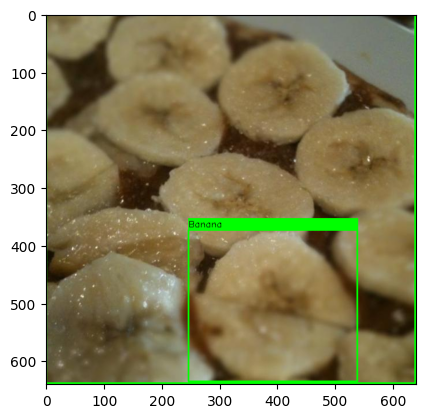

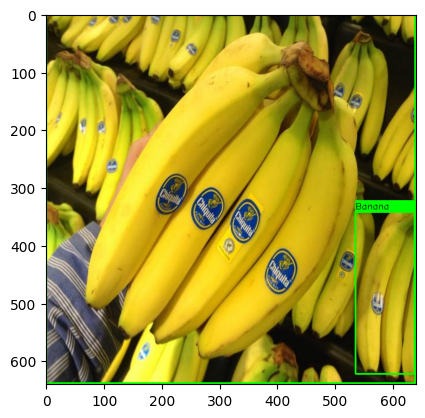

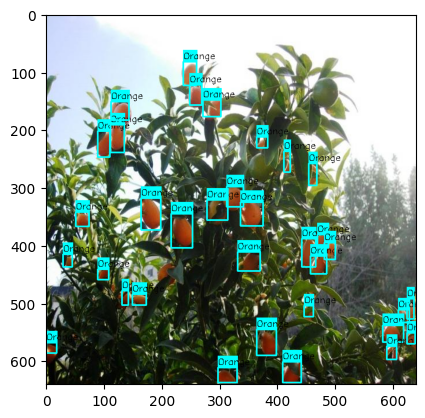

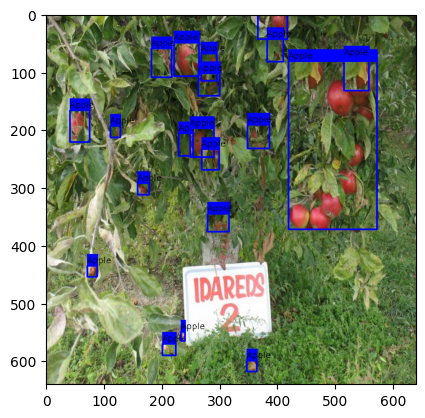

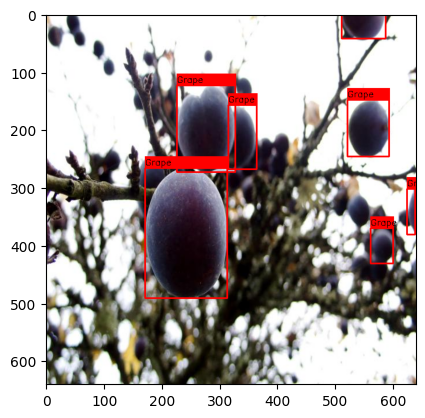

In [ ]:
train_images_dir= os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)
train_labels_dir= os.path.join(config.DATA_DIR, config.TRAIN_LABELS_DIR)
# Number of images to randomly select
num_images = 5
# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(train_images_dir).iterdir() if f.is_file()]
# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(train_labels_dir) / f"{selected_image_file.stem}.txt"
    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))
    # Get the list of class names from the 'data' dictionary
    class_list = config.CLASSES
    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    # Get the height and width of the image
    height, width, _ = image.shape
    # Create an empty list T
    T = []
    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")
            # Get the class id from the first element of the split list
            class_id = int(split[0])
            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]
            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])
            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]
            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)
            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))
        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

## **Fine-tuning YOLOv8**

### **Treinamento do modelo**

In [ ]:
config_dict = dict(data = os.path.join(config.DATA_DIR, 'data.yaml'),
                   epochs = 10,
                   batch = 16,
                   workers = 4,
                   imgsz = 640,
                   task = 'detect')

In [ ]:
def train(model_variant, config_dict):
    #define model
    model = YOLO(f"{model_variant}.pt")
    #train
    results = model.train(**config_dict)

In [ ]:
train(config.MODEL_NAME, config_dict)

100%|██████████| 83.7M/83.7M [00:00<00:00, 204MB/s]


Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/fruit-detection/Fruits-detection/data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.5MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/fruit-detection/Fruits-detection/train/labels... 7108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:04<00:00, 1514.91it/s]

train: WARNING ⚠️ /content/fruit-detection/Fruits-detection/train/images/3d8be4f881b8c54c_jpg.rf.0d7b6d095459cece040b47b246d807af.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/fruit-detection/Fruits-detection/train/images/3d8be4f881b8c54c_jpg.rf.64e869a9bedd5f012cc2a1129c6ca229.jpg: 1 duplicate labels removed


train: New cache created: /content/fruit-detection/Fruits-detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/fruit-detection/Fruits-detection/valid/labels... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:01<00:00, 819.66it/s]

val: WARNING ⚠️ /content/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed


val: New cache created: /content/fruit-detection/Fruits-detection/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.8G      1.038      2.102      1.341          4        640: 100%|██████████| 445/445 [06:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]

                   all        914       3227      0.218      0.203      0.114     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      11.3G      1.151      2.008      1.423         32        640: 100%|██████████| 445/445 [05:55<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.39it/s]

                   all        914       3227       0.25      0.256      0.157     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.2G      1.069       1.79      1.375          9        640: 100%|██████████| 445/445 [05:50<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.40it/s]

                   all        914       3227      0.263      0.215       0.14     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.2G      1.017      1.616      1.333          8        640: 100%|██████████| 445/445 [05:49<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.40it/s]

                   all        914       3227      0.305      0.298      0.218      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      11.2G     0.9504       1.49      1.292         21        640: 100%|██████████| 445/445 [05:51<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.36it/s]

                   all        914       3227      0.399      0.295      0.236      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      11.3G     0.9019      1.362      1.263          4        640: 100%|██████████| 445/445 [05:51<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


                   all        914       3227      0.426      0.347      0.306       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      11.2G     0.8412      1.229      1.219         12        640: 100%|██████████| 445/445 [05:52<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


                   all        914       3227      0.488      0.368      0.345       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      11.1G     0.8052      1.121      1.197         10        640: 100%|██████████| 445/445 [05:52<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.38it/s]

                   all        914       3227      0.521      0.356      0.373      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      11.2G      0.758      1.018      1.164          9        640: 100%|██████████| 445/445 [05:51<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.37it/s]

                   all        914       3227      0.567       0.41      0.438       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      11.3G     0.7241     0.9227      1.143          9        640: 100%|██████████| 445/445 [05:52<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


                   all        914       3227      0.592      0.421       0.46      0.308

10 epochs completed in 1.082 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


                   all        914       3227      0.592      0.421       0.46      0.307
                 Apple        914        557      0.646      0.436      0.493      0.346
                Banana        914        390      0.652      0.428      0.483       0.28
                 Grape        914        809       0.61      0.358      0.409      0.275
                Orange        914       1100      0.614      0.396      0.456        0.3
             Pineapple        914        154      0.556      0.357      0.382      0.246
            Watermelon        914        217      0.471      0.548      0.536      0.397
Speed: 0.2ms preprocess, 16.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train


## **Avaliando modelos treinado no conjunto de teste**

In [ ]:
path_model = "/content/runs/detect/train4/weights/best.pt"
best_model = YOLO(path_model)

In [ ]:
path_test = '/content/fruit-detection/Fruits-detection/test/images'
evaluate = best_model.predict(path_test, save=True, imgsz=640, conf=0.4)

## **Inferência**

In [ ]:
def show_result(result):
    boxes = result[0].boxes.xyxy.cpu().numpy()
    names = result[0].names
    confidences = result[0].boxes.conf

    # Convertendo a imagem para o formato RGB (se estiver em BGR)
    img = result[0].orig_img
    if img.shape[-1] == 3:  # Verifica se a imagem tem 3 canais (BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plotar as caixas delimitadoras na imagem
    for box, name, confidence in zip(boxes, names, confidences):
        if confidence >= 0.4:  # Exibir apenas caixas com confiança maior que 0.4
            box = [int(coord) for coord in box]
            plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], label=f'{name} ({confidence:.2f})', linewidth=2)

    # Mostrar a imagem com as caixas delimitadoras
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Apple

In [ ]:
url = 'https://s2-g1.glbimg.com/hWMKfZrVwHIPJJMgslhvGEuRKGw=/0x0:1920x1080/984x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2018/i/S/DJzZRhQWyub4r7FnBZrA/nc-maca-safra-181118.jpg'
result = best_model.predict(source=url,  conf=0.4)


Found https://s2-g1.glbimg.com/hWMKfZrVwHIPJJMgslhvGEuRKGw=/0x0:1920x1080/984x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2018/i/S/DJzZRhQWyub4r7FnBZrA/nc-maca-safra-181118.jpg locally at nc-maca-safra-181118.jpg
image 1/1 /content/nc-maca-safra-181118.jpg: 384x640 1 Apple, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


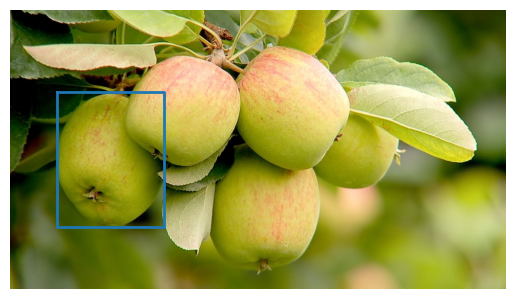

In [ ]:
show_result(result)

### Banana

In [ ]:
url = 'https://blog4.mfrural.com.br/wp-content/uploads/2020/06/plantar-banana.jpg'
result = best_model.predict(source=url,  conf=0.4)

100%|██████████| 38.4k/38.4k [00:00<00:00, 1.21MB/s]


image 1/1 /content/plantar-banana.jpg: 448x640 1 Banana, 243.4ms
Speed: 3.7ms preprocess, 243.4ms inference, 7.3ms postprocess per image at shape (1, 3, 448, 640)


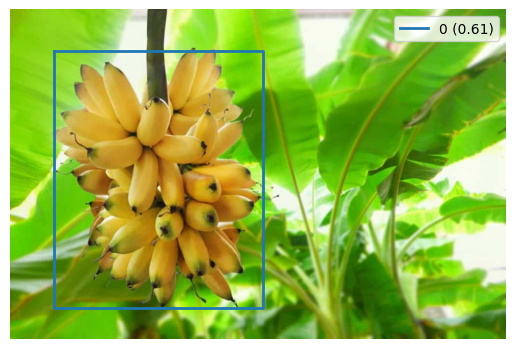

In [ ]:
show_result(result)

### Grape

In [ ]:
url = 'https://ocontadordecervejas.com.br/wp-content/uploads/thumbnails/quanto-tempo-leva-para-um-pe-de-uva-dar-frutos.jpg'
result = best_model.predict(source=url,  conf=0.4)


Found https://ocontadordecervejas.com.br/wp-content/uploads/thumbnails/quanto-tempo-leva-para-um-pe-de-uva-dar-frutos.jpg locally at quanto-tempo-leva-para-um-pe-de-uva-dar-frutos.jpg
image 1/1 /content/quanto-tempo-leva-para-um-pe-de-uva-dar-frutos.jpg: 448x640 3 Grapes, 28.3ms
Speed: 2.4ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


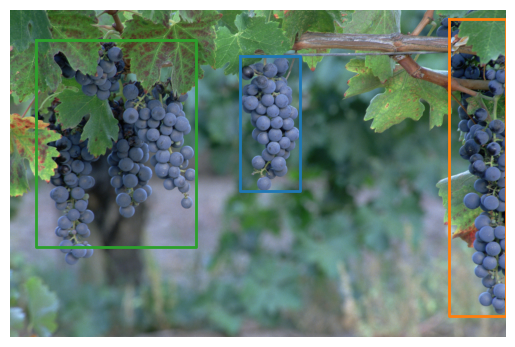

In [ ]:
show_result(result)

### Orange

In [ ]:
url = 'https://www.nt4gbi.com/wp-content/uploads/2023/04/Como-saber-se-e-pe-de-laranja-ou-limao.jpg'
result = best_model.predict(source=url,  conf=0.4)

100%|██████████| 206k/206k [00:00<00:00, 2.94MB/s]

image 1/1 /content/Como-saber-se-e-pe-de-laranja-ou-limao.jpg: 384x640 1 Orange, 26.1ms
Speed: 1.9ms preprocess, 26.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


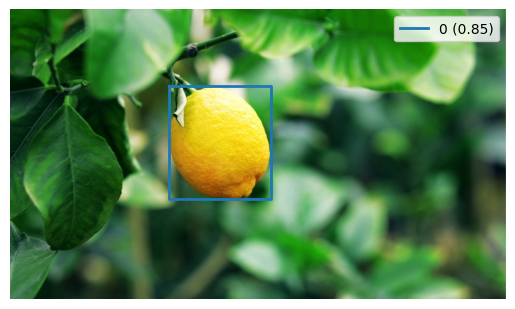

In [ ]:
show_result(result)

In [ ]:
url = 'https://www.nt4gbi.com/wp-content/uploads/2023/04/Quanto-tempo-leva-um-pe-de-laranja-para-dar-frutos.jpg'
result = best_model.predict(source=url,  conf=0.4)

100%|██████████| 195k/195k [00:00<00:00, 2.82MB/s]

image 1/1 /content/Quanto-tempo-leva-um-pe-de-laranja-para-dar-frutos.jpg: 384x640 2 Oranges, 25.3ms
Speed: 2.0ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


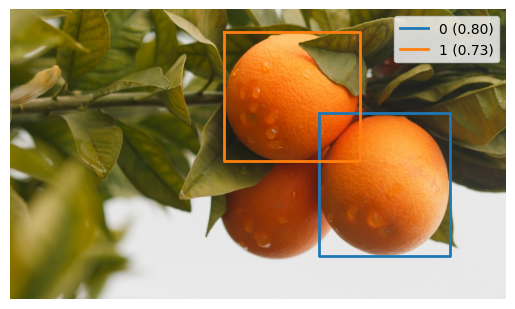

In [ ]:
show_result(result)

### Pineapple

In [ ]:
url = 'https://imagens-revista.vivadecora.com.br/uploads/2021/08/Aprenda-dicas-e-truques-de-como-plantar-abacaxi-em-casa.-Foto-MF-Magazine-MF-Rural.jpg'
result = best_model.predict(source=url,  conf=0.4)

100%|██████████| 114k/114k [00:00<00:00, 491kB/s] 


image 1/1 /content/Aprenda-dicas-e-truques-de-como-plantar-abacaxi-em-casa.-Foto-MF-Magazine-MF-Rural.jpg: 416x640 1 Pineapple, 77.7ms
Speed: 2.4ms preprocess, 77.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


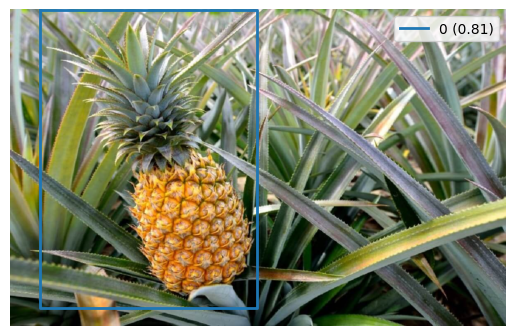

In [ ]:
show_result(result)

### Watermelon

In [ ]:
url = 'https://alavoura.com.br/wp-content/uploads/2020/09/Agricultores-investem-no-cultivo-irrigado-de-melancia-como-alternativa-de-renda-no-Norte-de-MT-1-e1599056081966.jpg'
result = best_model.predict(source=url,  conf=0.4)

100%|██████████| 97.2k/97.2k [00:00<00:00, 734kB/s]

image 1/1 /content/Agricultores-investem-no-cultivo-irrigado-de-melancia-como-alternativa-de-renda-no-Norte-de-MT-1-e1599056081966.jpg: 480x640 2 Watermelons, 29.3ms
Speed: 2.6ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


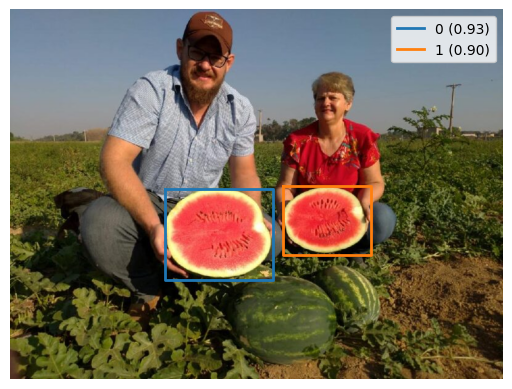

In [ ]:
show_result(result)

## **Salvando modelo no drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# caminho para o modelo no Colab
colab_model_path = '/content/runs' #ckpt_best, ckpt_latest, average_model
# caminho para salvar o modelo no Google Drive
drive_model_path = '/content/drive/MyDrive/TCC/Pesos/Yolov8'
# copiando o modelo do Colab para o Google Drive
shutil.copytree(colab_model_path, drive_model_path)

print(f'Modelo salvo com sucesso em {drive_model_path}')

Modelo salvo com sucesso em /content/drive/MyDrive/New
